Hunter Bennett | Glass Lab | Kupffer Strains Project | February 24 2021  

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Differential scatter plot similar to those make in Link et al. 2018 showing differential peaks at fc > 2 and fc > 4.

In [29]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 300
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('ticks')
# get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [31]:
if not os.path.isdir('./fancy_figures/'):
    os.mkdir('./fancy_figures/')

### Import differential peaks

In [32]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (61711, 25)
getDiffExpression selected transcripts (60547, 33)
annotatePeaks selected peaks (60547, 25)


In [33]:
drop_samp = ['AJ15A']
peaks = peaks.drop(
    columns=peaks.columns[peaks.columns.str.contains('|'.join(drop_samp))])
peak_mat = peak_mat.drop(
    columns=peak_mat.columns[peak_mat.columns.str.contains('|'.join(drop_samp))])
peak_mat_quant = peak_mat_quant.drop(
    columns=peak_mat_quant.columns[peak_mat_quant.columns.str.contains('|'.join(drop_samp))])

In [34]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

# Set parameters that don't change throughout plotting

In [65]:
comps = ['00_c57 vs. 01_balbc',
         '00_c57 vs. 02_aj',
         '01_balbc vs. 02_aj']

labels = [['C57BL/6J\nlog2 (tag counts + 1)', 'BALB/cJ\nlog2 (tag counts + 1)'],
          ['C57BL/6J\nlog2 (tag counts + 1)', 'AJ\nlog2 (tag counts + 1)'],
          ['BALB/cJ\nlog2 (tag counts + 1)', 'AJ\nlog2 (tag counts + 1)']]

groups = [[[0,1],[2,3]],
         [[0,1],[4,5]],
         [[2,3],[4,5]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

# set plotting thresholds
pthresh = 0.05
lfcthresh = (1,2)
dotsize = 0.5
ax_max = 16
n_yticks = 5
ytickstep = 3

# Strain specific coloring

In [66]:
colors = [['#636363', '#6baed6', '#3182bd', '#74c476', '#31a354'],
          ['#636363', '#fb6a4a', '#de2d26', '#74c476', '#31a354'],
          ['#636363', '#fb6a4a', '#de2d26', '#6baed6', '#3182bd']]

filename='h3k27ac_diffpeak_scatter_twothresh_sixcolor.pdf'

In [67]:
fig, axs = plt.subplots(1,3, figsize=(11.5,3))
plt.subplots_adjust(wspace=0.5)

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)):
    
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.adj_pval >= pthresh])
    de_sig_up_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (de.log2fc >= lfcthresh[0])])
    de_sig_up_fc2 = de.reindex(de.index[(de.adj_pval < pthresh) & (de.log2fc >= lfcthresh[1])])
    de_sig_dn_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (de.log2fc <= -lfcthresh[0])])
    de_sig_dn_fc2 = de.reindex(de.index[(de.adj_pval < pthresh) & (de.log2fc <= -lfcthresh[1])])
    
    for df, c, in zip([de_nonsig, de_sig_up_fc1, de_sig_up_fc2, de_sig_dn_fc1, de_sig_dn_fc2],
                      color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize)
    
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=10)
    ax.set_ylabel(labs[1], fontsize=10)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    
plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')
plt.close()

# Non-specific coloring

In [68]:
colors = [['#636363', '#fb6a4a', '#de2d26'],
          ['#636363', '#fb6a4a', '#de2d26'],
          ['#636363', '#fb6a4a', '#de2d26']]
    
filename='h3k27ac_diffpeak_scatter_twothresh_twocolor.pdf'

In [69]:
fig, axs = plt.subplots(1,3, figsize=(11.5,3))
plt.subplots_adjust(wspace=0.5)

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)):
    
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.adj_pval >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (np.abs(de.log2fc) >= lfcthresh[0])])
    de_sig_fc2 = de.reindex(de.index[(de.adj_pval < pthresh) & (np.abs(de.log2fc) >= lfcthresh[1])])
    
    for df, c in zip([de_nonsig, de_sig_fc1, de_sig_fc2],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize)
     
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=10)
    ax.set_ylabel(labs[1], fontsize=10)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')
plt.close()

# One logfc threshold

In [70]:
colors = [['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26']]

filename='h3k27ac_diffpeak_scatter_onethresh_onecolor.pdf'

In [71]:
fig, axs = plt.subplots(1,3, figsize=(11.5,3))
plt.subplots_adjust(wspace=0.5)

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)):

    
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.adj_pval >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (np.abs(de.log2fc) >= lfcthresh[0])])
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize)
     
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=10)
    ax.set_ylabel(labs[1], fontsize=10)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')
plt.close()

Try with rasterizing

In [72]:
filename='h3k27ac_diffpeak_scatter_onethresh_onecolor_raster.pdf'

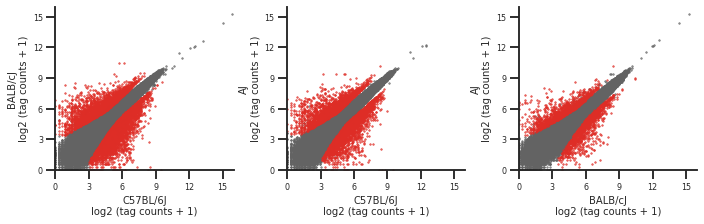

In [73]:
fig, axs = plt.subplots(1,3, figsize=(11.5,3))
plt.subplots_adjust(wspace=0.3)

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)):

    
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.adj_pval >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (np.abs(de.log2fc) >= lfcthresh[0])])
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True)
     
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=10)
    ax.set_ylabel(labs[1], fontsize=10)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontsize=8)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')
# plt.close()